In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


In [2]:
import pandas as pd
import numpy as np
import nltk
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

# Download necessary NLTK components
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [3]:
# Prepare stop words and punctuation lists using NLTK
stopwords_list = set(stopwords.words('english'))
punctuations_list = set(string.punctuation)
lemmatizer = WordNetLemmatizer()

In [4]:
def tokenize_essay(essay_text, word_count_needed=False):
    # Process NaN values and tokenize text
    if isinstance(essay_text, float):
        processed_text = essay_text
    else:
        tokens = word_tokenize(essay_text)
        lemmatized_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens]
        filtered_tokens = [token for token in lemmatized_tokens if token not in stopwords_list and token not in punctuations_list]
        processed_text = " ".join(filtered_tokens)

    # Return word count if needed
    if word_count_needed:
        count_of_words = len(filtered_tokens)
        return processed_text, count_of_words
    else:
        return processed_text

# Load the dataset
essay_data = pd.read_csv("../input/llm-detect-ai-generated-text/train_essays.csv")

# Tokenization and text preprocessing
essay_data['tokenized_text'], essay_data['word_count'] = zip(*essay_data['text'].apply(tokenize_essay, word_count_needed=True))

In [5]:
# Construct a word vector matrix and vocabulary list
vectorizer = CountVectorizer()
X_matrix = vectorizer.fit_transform(essay_data['tokenized_text'])
vocabulary = vectorizer.get_feature_names_out()

# Filter out rare words that occur less than five times
word_counts = X_matrix.sum(axis=0).A1  # Convert from matrix to array
min_occurrences = 5
filtered_vocab_indices = np.where(word_counts >= min_occurrences)[0]
filtered_vocab = np.array(vocabulary)[filtered_vocab_indices]

# Create a reverse index for the filtered vocabulary
reverse_index = {word: idx for idx, word in enumerate(filtered_vocab)}

In [6]:
# Compute probabilities of word occurrences for the filtered vocabulary
total_docs = len(essay_data)
prob_of_word_occurrence = {word: word_counts[reverse_index[word]] / total_docs for word in filtered_vocab}

# Define indices for each class (LLM or Human)
indices_of_llm = essay_data[essay_data['generated'] == 1].index
indices_of_human = essay_data[essay_data['generated'] == 0].index

# Calculate class-based probabilities for the filtered vocabulary
X_filtered = X_matrix[:, filtered_vocab_indices]

llm_word_occurrences = X_filtered[indices_of_llm].sum(axis=0).A1
human_word_occurrences = X_filtered[indices_of_human].sum(axis=0).A1

llm_probabilities = {word: llm_word_occurrences[reverse_index[word]] / len(indices_of_llm) for word in filtered_vocab}
human_probabilities = {word: human_word_occurrences[reverse_index[word]] / len(indices_of_human) for word in filtered_vocab}

In [7]:
class BayesianTextClassifier:
    def __init__(self, alpha=1):
        self.alpha = alpha
        self.class_probs = None
        self.word_probs = None

    def fit(self, X, y):
        num_docs, vocab_size = X.shape
        unique_classes = np.unique(y)
        num_classes = len(unique_classes)

        # Calculate class probabilities
        self.class_probs = np.zeros(num_classes)
        for i, c in enumerate(unique_classes):
            self.class_probs[i] = np.sum(y == c) / num_docs

        # Calculate word probabilities with Laplace smoothing
        self.word_probs = np.zeros((num_classes, vocab_size))
        for i, c in enumerate(unique_classes):
            class_docs = X[y == c]
            total_words_in_class = np.sum(class_docs)
            self.word_probs[i] = (np.sum(class_docs, axis=0) + self.alpha) / (total_words_in_class + self.alpha * vocab_size)

            
    def predict_proba(self, X):
        num_docs, _ = X.shape
        num_classes, vocab_size = self.word_probs.shape

        # Use log probabilities to avoid underflow
        log_class_probs = np.log(self.class_probs)
        log_word_probs = np.log(self.word_probs)

        # Calculate log likelihoods for each class
        log_likelihoods = np.zeros((num_docs, num_classes))
        for i in range(num_docs):
            doc = X[i].toarray().flatten()  # Convert the sparse matrix to a dense array
            log_likelihoods[i] = np.sum(log_word_probs * doc, axis=1) + log_class_probs

        # Convert log likelihoods to probabilities using softmax
        exp_log_likelihoods = np.exp(log_likelihoods - np.max(log_likelihoods, axis=1, keepdims=True))
        probabilities = exp_log_likelihoods / np.sum(exp_log_likelihoods, axis=1, keepdims=True)

        return probabilities        
    
    def predict(self, X):
        num_docs, _ = X.shape
        num_classes, vocab_size = self.word_probs.shape

        # Use log probabilities to avoid underflow
        log_class_probs = np.log(self.class_probs)
        log_word_probs = np.log(self.word_probs)

        # Calculate log likelihoods for each class
        log_likelihoods = np.zeros((num_docs, num_classes))
        for i in range(num_docs):
            doc = X[i].toarray().flatten()  # Convert the sparse matrix to a dense array
            log_likelihoods[i] = np.sum(log_word_probs * doc, axis=1) + log_class_probs

        # Predict the class with the highest log likelihood
        predictions = np.argmax(log_likelihoods, axis=1)
        return predictions

In [8]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_matrix, essay_data['generated'], test_size=0.2, random_state=42)

In [9]:
# Initialize and train classifier
alpha_value = 1
bayesian_classifier = BayesianTextClassifier(alpha=alpha_value)
bayesian_classifier.fit(X_train, y_train)

In [10]:
# Predictions and evaluation
predictions = bayesian_classifier.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       275
           1       0.00      0.00      0.00         1

    accuracy                           0.98       276
   macro avg       0.50      0.49      0.49       276
weighted avg       0.99      0.98      0.99       276



In [11]:
# Experiment with different smoothing values
smoothing_values = [0.1, 0.5, 1, 2, 5]
for alpha in smoothing_values:
    classifier_with_smoothing = BayesianTextClassifier(alpha=alpha)
    classifier_with_smoothing.fit(X_train, y_train)
    preds_with_smoothing = classifier_with_smoothing.predict(X_test)
    accuracy = np.mean(preds_with_smoothing == y_test)
    print(f"Accuracy with alpha={alpha}: {accuracy}")

Accuracy with alpha=0.1: 0.9746376811594203
Accuracy with alpha=0.5: 0.9782608695652174
Accuracy with alpha=1: 0.9782608695652174
Accuracy with alpha=2: 0.9818840579710145
Accuracy with alpha=5: 0.9927536231884058


In [12]:
# Assuming `llm_probabilities` and `human_probabilities` are now dictionaries with filtered vocab
top_llm_words = sorted(llm_probabilities, key=llm_probabilities.get, reverse=True)[:10]
top_human_words = sorted(human_probabilities, key=human_probabilities.get, reverse=True)[:10]

In [13]:
print("Top words for LLM class:")
print(top_llm_words)

print("Top words for Human class:")
print(top_human_words)

Top words for LLM class:
['vote', 'state', 'electoral', 'college', 'win', 'candidate', 'car', 'elector', 'president', 'citizen']
Top words for Human class:
['car', 'vote', 'electoral', 'people', 'college', 'state', 'president', 'use', 'elector', 'candidate']


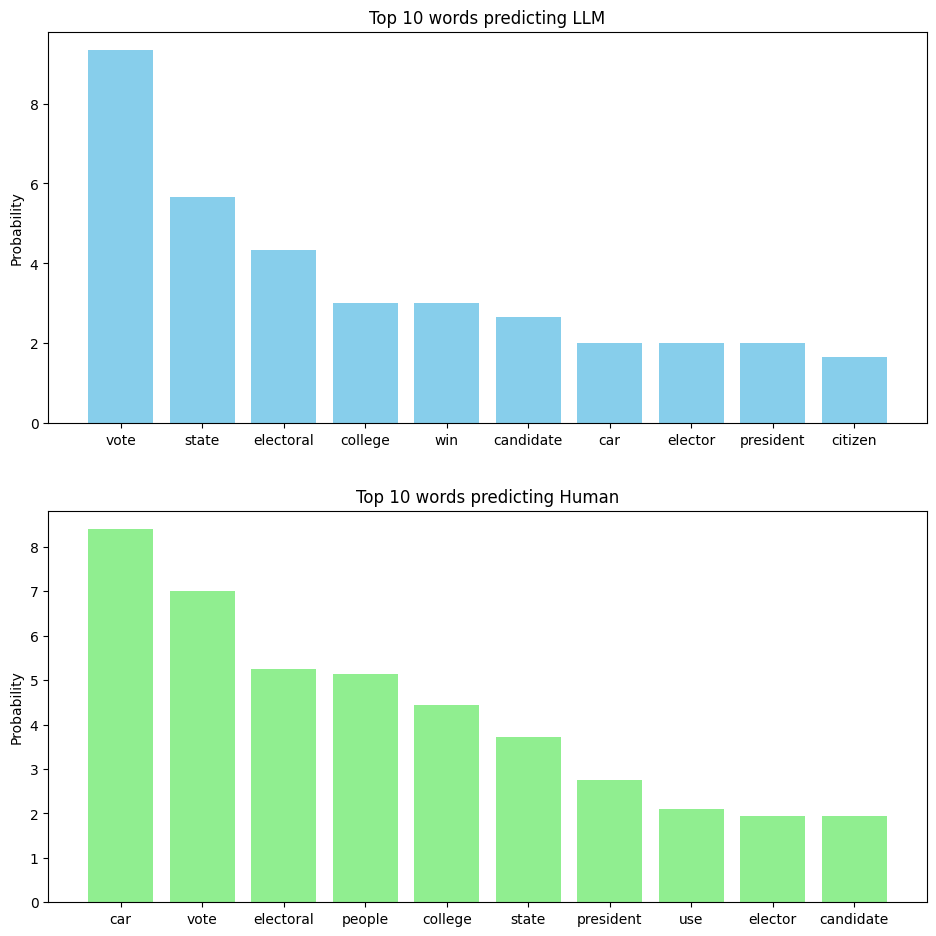

In [14]:
import matplotlib.pyplot as plt
# Assuming `llm_probabilities` and `human_probabilities` are now dictionaries with filtered vocab
# and you have identified the top words for each class in `top_llm_words` and `top_human_words`
top_llm_words_sorted = {word: llm_probabilities[word] for word in top_llm_words}
top_human_words_sorted = {word: human_probabilities[word] for word in top_human_words}

# Create bar charts using matplotlib
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Bar chart for LLM words
axes[0].bar(top_llm_words_sorted.keys(), top_llm_words_sorted.values(), color='skyblue')
axes[0].set_title('Top 10 words predicting LLM')
axes[0].set_ylabel('Probability')

# Bar chart for Human words
axes[1].bar(top_human_words_sorted.keys(), top_human_words_sorted.values(), color='lightgreen')
axes[1].set_title('Top 10 words predicting Human')
axes[1].set_ylabel('Probability')

# Add some spacing between the charts
plt.tight_layout(pad=3.0)

# Show the plots
plt.show()


In [15]:
# Load the test dataset (make sure the path is correct)
test_data = pd.read_csv("../input/llm-detect-ai-generated-text/test_essays.csv")

# Tokenize the essays in the test dataset
test_data['tokenized_text'] = test_data['text'].apply(tokenize_essay)

# Transform the tokenized essays into a matrix of token counts
X_test_matrix = vectorizer.transform(test_data['tokenized_text'])

# Generate the probability predictions
predictions_proba = bayesian_classifier.predict_proba(X_test_matrix)

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'id': test_data['id'],  # Use the correct ID column name as per your test_data
    'generated': predictions_proba[:, 1]  # Assuming the second column is the predicted probabilities
})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)

In [16]:
submission_df.head()

,id,generated
0,0000aaaa,0.001815
1,1111bbbb,0.001815
2,2222cccc,0.001815


In [17]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         3 non-null      object 
 1   generated  3 non-null      float64
dtypes: float64(1), object(1)
memory usage: 176.0+ bytes
